In [3]:
#importing required packages 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import defaultdict
from scipy.stats import pearsonr, chi2_contingency
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
import datetime
import time
import pickle
import os
from sklearn import naive_bayes
from sklearn import discriminant_analysis
import seaborn as sns
import MySQLdb

In [51]:
#creating a connection to our MySQL server
conn = MySQLdb.connect(host=dsn_hostname, port=dsn_port, user=dsn_uid, passwd=dsn_pwd, db=dsn_database)
# ^parameter values above were removed to prevent password leakage issues 
c=conn.cursor()
c.execute("""SELECT * FROM lendingclub3""")

4281

In [2]:
#reading in our data locally through our main csv file 
accepted_df = pd.read_csv('accepted_2007_to_2018Q4.csv', sep = ',')

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
accepted_df.isna().sum().sum()/(accepted_df.shape[0] * accepted_df.shape[1])

0.3178005318405443

In [5]:
accepted_df.loan_amnt.sum()

34016115925.0

In [63]:
#mySQLdb query to return the same albeit from our smaller accepted_df dataset
c.execute("""SELECT sum(loan_amnt) FROM lendingclub3""")
c.fetchall()

((Decimal('65256750'),),)

In [4]:
#creating function to quickly get an idea of values that comprise feature 
def variable_expl(variable):
    print(accepted_df[variable].value_counts())
    print(' ')
    print('Number of NA\'s is:', accepted_df[variable].isna().sum())
    print('Number of unique values is:', accepted_df[variable].nunique())
    if accepted_df[variable].dtype == 'float64' or accepted_df[variable].dtype == 'int64':
        print('Mean is:', np.mean(accepted_df[variable]))
        print('Std.Dev is:', np.std(accepted_df[variable]))
    else:
        return False

In [5]:
#creating function to return correlation value between two features 
def corr_value(variable1, variable2):
    print(accepted_df[variable1].corr(accepted_df[variable2]))

In [6]:
#creating a function that can print full series values in Jupyter notebook
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [7]:
#creating a function to return correlation values between numeric variables
#num_feat2 needs to be instantiated in order for correlation to run
from collections import defaultdict

        
def correlation(variable):
    dict1 = defaultdict(int)
    for x in accepted_df[num_feat2].columns.values:
        corr1 = accepted_df[x].corr(accepted_df[variable])
        dict1[x] = abs(corr1)
    return sorted(dict1.items(), key = lambda x: x[1], reverse = True)

In [8]:
#creating month_dict to map str month values to int
month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [9]:
#dropping observations with NA's for loan status
accepted_df = accepted_df.dropna(subset = ['loan_status'])

#creates issue_d_year and issue_d_month variables that will be later used to filter the dataframe 

def date_transformation(df):
    df[['earliest_cr_line_month','earliest_cr_line_year']] = df['earliest_cr_line'].str.split('-', expand = True)
    df['earliest_cr_line_year'] = df['earliest_cr_line_year'].fillna('2019')
    df['earliest_cr_line_month'] = df['earliest_cr_line_month'].fillna('Jun')
    df[['issue_d_month','issue_d_year']] = df['issue_d'].str.split('-', expand = True)
    df.issue_d_year = df.issue_d_year.astype('int64')
    
    #mapping string months to num months for datetime conversion
    month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
    df['issue_d_month_num'] = df['issue_d_month'][:] 
    df['issue_d_month_num'] = df['issue_d_month_num'].replace(month_dict)
    df['issue_d_date'] = str('15/') + df['issue_d_month_num'].astype(str) + '/' + df['issue_d_year'].astype(str)
    df['issue_d_date'] = pd.to_datetime(df['issue_d_date'], infer_datetime_format=True)
    df.drop(['issue_d_month_num'], axis = 1, inplace = True)
    df['Year'] = pd.DatetimeIndex(df['issue_d_date']).year

    return df.shape

date_transformation(accepted_df)

(2260668, 157)

In [10]:
#selecting only 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019 data
accepted_df = accepted_df[accepted_df['issue_d_year'].isin([2012,2013,2014,2015,2016,2017,2018,2019])]

#IMPUTATION

#fillmean values 
fillmean = ['annual_inc','delinq_amnt','acc_now_delinq','delinq_2yrs','dti','revol_util','inq_last_6mths',
           'open_acc','pub_rec','open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il',
           'il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','total_rev_hi_lim','inq_fi',
           'total_cu_tl','inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util',
           'mo_sin_old_il_acct','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mths_since_recent_bc',
           'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_bc_sats','num_bc_tl','num_il_tl',
           'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',
           'num_tl_90g_dpd_24m','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_bc_limit',
           'total_il_high_credit_limit']


#missing values here likely mean absence of the feature for that observation. 
fillzero = ['open_acc','pub_rec','inq_last_6mths','tax_liens','collections_12_mths_ex_med',
           'chargeoff_within_12_mths','pub_rec_bankruptcies','emp_length','tot_coll_amt']


def fillvars(accepted_df):
    for x in fillmean:
        try:
            accepted_df[x] = accepted_df[x].fillna(accepted_df[x].mean())
        except:
            continue
    for d in fillzero:
        try:
            accepted_df[d] = accepted_df[d].fillna(0)
        except:
            continue
fillvars(accepted_df)
    

In [11]:
#dropping irrelevant or missing data features from the start

#dropping certain variables from the get-go in order to reduce processing time during multicollinearity analysis
accepted_df = accepted_df.drop(['member_id','id','funded_amnt_inv','url','desc'], axis = 1)
#looking at variables with highest NA counts
accepted_df_nas = (accepted_df.isna().sum()/accepted_df.shape[0]).reset_index()
accepted_df_nas.columns = ['Feature','Percent_Missing']
accepted_df_nas = accepted_df_nas.sort_values(by = 'Percent_Missing')
#getting index list of variables wiht > 50% missing values 
index1 = list(accepted_df_nas[accepted_df_nas['Percent_Missing'] > 0.5].index)
#dropping the columns that have missing values > 0.5
accepted_df.drop(accepted_df.columns[index1], axis = 1, inplace = True)
#since policy_code has only one value, drop this column as well
accepted_df = accepted_df.drop(['policy_code'], axis = 1)
#zip_code variable has last two digits of zip_code missing, so we can safely drop this one 
accepted_df = accepted_df.drop(['zip_code'], axis = 1)
#drop last_payment_d variable because this variable would not be accessible to investors and would introduce data leakage
accepted_df.drop(['last_pymnt_d','collection_recovery_fee','recoveries'], axis = 1, inplace = True)
#drop last_fico_range_low because of high correlation with last_fico_range_high
accepted_df.drop(['last_fico_range_low'], axis = 1, inplace = True)
#cleaning categorical variables 
#term should be converted to numeric
accepted_df['term'] = accepted_df['term'].replace({' 36 months':36,' 60 months':60})
#85% of last_credit_pull_d values are Mar-2019, so drop
accepted_df.drop(['last_credit_pull_d'], axis = 1, inplace = True)
#title and purpose variables are quasi-identical, so drop one
accepted_df.drop(['title'], axis = 1, inplace = True)
#creating a new variable to capture number of years of oldest credit line, defined as issue_d - earliest_cr_line

In [12]:
accepted_df['earliest_cr_line_month_num'] = accepted_df['earliest_cr_line_month'][:] 
accepted_df['earliest_cr_line_month_num'] = accepted_df['earliest_cr_line_month_num'].replace(month_dict)
accepted_df['earliest_cr_line_date'] = str('15/') + accepted_df['earliest_cr_line_month_num'].astype(str) + '/' + accepted_df['earliest_cr_line_year'].astype(str)
accepted_df.drop(['earliest_cr_line_month_num'], axis = 1, inplace = True)
accepted_df['earliest_cr_line_date'] = pd.to_datetime(accepted_df['earliest_cr_line_date'], infer_datetime_format=True)
#creating new variable capturing amount of years of oldest credit line 
accepted_df['earliest_credit_line_years'] = accepted_df['issue_d_date'] - accepted_df['earliest_cr_line_date'] 
#dropping debt_settlement_flag because this would introduce data leakage into the dataset
#dropping 'earliest_cr_line_month','earliest_cr_line_year','issue_d_month' because these are now captured in earliest_credit_line_yearsa nd issue_d_date
accepted_df.drop(['debt_settlement_flag', 'earliest_cr_line_month','earliest_cr_line_year','issue_d_month'], axis = 1, inplace = True)
#dropping earliest_cr_line
accepted_df.drop(['earliest_cr_line'], axis = 1, inplace = True)
#dropping emp_title because mapping to general categories i.e. Director or President 
# would most likely be highly correlated with income and would be very computationally/time expensive
accepted_df.drop(['emp_title'],axis = 1, inplace = True)
#dropping issue_d_year because year already captured in issue_d_date
accepted_df.drop(['issue_d_year'],axis = 1, inplace = True)
#dropping issue_d because year already captured in issue_d_date
accepted_df.drop(['issue_d'],axis = 1, inplace = True)
#mapping 10+ years to 11 years and <1 years to 0 years in emp_length and converting this to a float
accepted_df['emp_length'] = accepted_df['emp_length'].replace({'< 1 year': '0 years', '10+ years': '11 years'})
accepted_df['emp_length'] = accepted_df['emp_length'].str.extract('(\d+)').astype('float')
#replacing values in application_type_variable
accepted_df['application_type'] = accepted_df['application_type'].replace({'Individual':'Ind','Joint App':'Joint'}) 
#dropping pymnt_plan and hardship_flag because keeping these would constitute data leakage 
accepted_df.drop(['pymnt_plan','hardship_flag'],axis = 1, inplace = True)
#mapping our dependent variable loan_status to 0/1 values
accepted_df['loan_status'] = accepted_df['loan_status'].isin(['Fully Paid','Current','In Grace Period','Does not meet the credit policy. Status:Fully Paid']).astype('int64')

In [ ]:
#exploratory data analysis of emp_length vs loan_status

eda1 = accepted_df.groupby(['addr_state','emp_length'])['loan_status'].mean().to_frame().reset_index()
eda1['loan_status'] = 1 - eda1['loan_status']
eda1['above_average'] = np.where(eda1['loan_status'] > np.mean(eda1['loan_status']), 1, 0)
eda1.loc[eda1['emp_length'] == 11, 'emp_length'] = 10
eda1['emp_length'].value_counts()

In [158]:
#pickling this emp_length groupby dataframe
with open('eda1.pickle','wb') as eda1_file:
     pickle.dump(eda1, eda1_file)

In [67]:
#mySQLdb query to return the same EDA albeit from our smaller accepted_df dataset and looking at int_rate instead of 
#default rate
c.execute("""SELECT emp_length, avg(int_rate) FROM lendingclub3 group by emp_length""")
c.fetchall()

(('10+ years', 11.939009900990017),
 ('3 years', 12.62005333333331),
 ('4 years', 12.597999999999987),
 ('6 years', 12.743684210526316),
 ('1 year', 12.53996336996336),
 ('7 years', 12.652661870503605),
 ('8 years', 12.287822222222218),
 ('5 years', 12.310078124999999),
 ('2 years', 12.60452970297026),
 ('9 years', 12.126449275362326),
 ('< 1 year', 12.444197247706404),
 ('', 12.418057142857153))

In [ ]:
#creating dataframe of average default rates by US State

eda2 = accepted_df.loc[accepted_df['Year'] > 2014].groupby(['addr_state','Year'])['loan_status'].mean().to_frame().reset_index()
eda2['loan_status'] = 1 - eda2['loan_status']
eda2

In [34]:
#looking at distribution of loan grades by state
eda3 = accepted_df.groupby(['addr_state','grade']).agg({'loan_amnt':'sum'}) #.to_frame().reset_index()
eda3 = eda3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
eda3
with open('eda3.pickle','wb') as eda3_file:
    pickle.dump(eda3, eda3_file)

In [70]:
#mySQLdb query to return the same albeit from our smaller accepted_df dataset
c.execute("""SELECT grade, sum(loan_amnt) FROM lendingclub3 group by grade""")
c.fetchall()

(('C', Decimal('18553150')),
 ('B', Decimal('17465500')),
 ('F', Decimal('1896825')),
 ('A', Decimal('11451200')),
 ('E', Decimal('5497025')),
 ('D', Decimal('10029475')),
 ('G', Decimal('363575')))

In [113]:
eda4 = accepted_df.groupby(['addr_state','grade']).agg({'int_rate':'mean'}).reset_index()
with open('eda4.pickle','wb') as eda4_file:
    pickle.dump(eda4, eda4_file)

In [68]:
#mySQLdb query to return the same albeit from our smaller accepted_df dataset
c.execute("""SELECT grade, avg(int_rate) FROM lendingclub3 group by grade""")
c.fetchall()

(('C', 13.321387283236923),
 ('B', 9.974026377036388),
 ('F', 23.39863157894738),
 ('A', 6.832931677018545),
 ('E', 19.921176470588176),
 ('D', 16.993101045296278),
 ('G', 27.628888888888895))

In [ ]:
eda5 = accepted_df.groupby(['addr_state','last_fico_range_high']).agg({'loan_status':'mean','int_rate':'mean'}).reset_index()
eda5

In [ ]:
#mySQLdb query to return the same albeit from our smaller accepted_df dataset
c.execute("""SELECT last_fico_range_high, avg(int_rate) FROM lendingclub3 group by last_fico_range_high""")
c.fetchall()

In [147]:
with open('eda5.pickle','wb') as eda5_file:
    pickle.dump(eda5, eda5_file)

In [22]:
#pickling this addr_state groupby dataframe
with open('eda2.pickle', 'wb') as eda2_file:
    pickle.dump(eda2, eda2_file)

In [13]:
#creating list of all numeric variable names
num_feat2 = []
for x in accepted_df.columns.values:
    if accepted_df[x].dtype == 'int64' or accepted_df[x].dtype == 'float64':
        num_feat2.append(x)
    else:
        continue

print(len(num_feat2))

#creating list of all categorical variable names
cat_feat = []
for var in accepted_df.columns:
    if accepted_df[var].dtype == 'O':
        cat_feat.append(var)
    else:
        continue
        
print(len(cat_feat))

82
9


In [14]:
#addressing multicollinearity in categorical variables
#dropping categorical variables that are highly correlated with one another
cat_feat = []
for var in accepted_df.columns:
    if accepted_df[var].dtype == 'O' and var != 'loan_status':
        cat_feat.append(var)
    else:
        continue
print('Num Features',len(cat_feat))
try:
    cat_feat.remove(0)
except:
    pass
    
comb_cat_feat = list(combinations(cat_feat, 2))
print('Num combinations',len(comb_cat_feat))

corrdict2 = defaultdict(int)
for comb in comb_cat_feat:
    table = pd.pivot_table(accepted_df, values='loan_amnt', index=comb[0], columns=comb[1], aggfunc='count').fillna(0)
    corr = np.sqrt(chi2_contingency(table)[0] / (table.values.sum() * (np.min(table.shape) - 1) ) )
    corrdict2[comb] = np.abs(corr)
corrdict2

#creating function to drop first feature in highly correlated categorical feature pairs 
#for value = 0.85, we are just dropping grade feature
def drop_corr_cat(value):
    for x in list(filter(lambda x: x[1] > value, corrdict2.items())):
        try:
            accepted_df.drop([x[0][0]], axis = 1, inplace = True)
            print(x)
        except:
            continue
drop_corr_cat(0.85)

Num Features 9
Num combinations 36
(('grade', 'sub_grade'), 1.0)


In [ ]:
#exploring pairs of highly correlated numeric variables
comb_num_feat = list(combinations(num_feat2, 2))
corrdict = defaultdict(int)
for comb in comb_num_feat:
    try:
        corr = accepted_df[comb[0]].corr(accepted_df[comb[1]])
        corrdict[comb] = abs(corr)
    except:
        continue
print_full(corrdict)

#addressing multicollinearity in numeric variables
#dropping numeric variables that are highly correlated with one another
vars = ['']
def variable_drop(corrdict, value):
    filtered_dict = dict(filter(lambda x: x[1] > value, corrdict.items()))
    dropped_variables = []
    var1 = ['loan_amnt','loan_status']
    for k,v in filtered_dict.items():
        if k[0] not in var1:
            try:
                accepted_df.drop(k[0], axis = 1, inplace = True)
                print('Highly correlated pair:',k,v)
                dropped_variables.append(k[0])
            except:
                print('Next')
                continue
        else:
            continue
    print(dropped_variables)
variable_drop(corrdict, 0.85)

In [16]:
#filling missing values in additional variables
accepted_df['pct_tl_nvr_dlq'] = accepted_df['pct_tl_nvr_dlq'].fillna(accepted_df['pct_tl_nvr_dlq'].mean())
accepted_df['mo_sin_old_rev_tl_op'] = accepted_df['mo_sin_old_rev_tl_op'].fillna(accepted_df['mo_sin_old_rev_tl_op'].mean())
accepted_df['mort_acc'] = accepted_df['mort_acc'].fillna(accepted_df['mort_acc'].mean())
accepted_df['emp_length'] = accepted_df['emp_length'].fillna(accepted_df['emp_length'].mean())

In [17]:
#creating train and test datasets

#targetdf is all 2018 data 
targetdf = accepted_df[accepted_df['Year'] == 2018]

#traindf is all non-2018 data
traindf = accepted_df[accepted_df['Year'] != 2018]

In [18]:
#dropping additional variables that may cause data leakage 
targetdf.drop(['Year'], axis = 1, inplace = True)
traindf.drop(['Year'], axis = 1, inplace = True)

traindf.drop(['out_prncp_inv'], axis = 1, inplace = True)
traindf.drop(['last_pymnt_amnt'], axis = 1, inplace = True)
traindf.drop(['total_rec_int'], axis = 1, inplace = True)
traindf.drop(['total_rec_late_fee'], axis = 1, inplace = True)
traindf.drop(['total_rec_prncp'], axis = 1, inplace = True)

targetdf.drop(['out_prncp_inv'], axis = 1, inplace = True)
targetdf.drop(['last_pymnt_amnt'], axis = 1, inplace = True)
targetdf.drop(['total_rec_int'], axis = 1, inplace = True)
targetdf.drop(['total_rec_late_fee'], axis = 1, inplace = True)
targetdf.drop(['total_rec_prncp'], axis = 1, inplace = True)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
#creating list of all categorical variable names
cat_feat = []
for var in accepted_df.columns:
    if var != 'loan_status' and accepted_df[var].dtype == 'O':
        cat_feat.append(var)
    else:
        continue


In [20]:
#creating x and y data for training data
train_target = traindf['loan_status'][:]
train_data = traindf.drop(['loan_status'], axis = 1)
#creating x and y data for 2018 target data 
test_target = targetdf['loan_status'][:]
test_data = targetdf.drop(['loan_status'], axis = 1)

In [21]:
#getting indices of categorical variables
cat_feat_ind = [train_data.columns.get_loc(c) for c in cat_feat]

In [ ]:
#ANALYSIS
#CATBOOST
#read up about catboost when preparing for interviews 
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
x_train, x_test, y_train, y_test = train_test_split(train_data, train_target, stratify = train_target, 
                                                    random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify = y_train, 
                                                    random_state = 0)
num = y_train.value_counts()
pool_train = Pool(x_train, y_train, cat_features = cat_feat_ind)
pool_test = Pool(x_test, y_test, cat_features = cat_feat_ind)
pool_val = Pool(x_val, y_val, cat_features = cat_feat_ind)
pool_2018 = Pool(test_data, test_target, cat_features = cat_feat_ind)

cat1 = CatBoostClassifier(learning_rate = 0.05,
                          iterations = 1000,
                          early_stopping_rounds=100,
                          class_weights = [1, num[0]/num[1]])

cat1.fit(pool_train, eval_set=pool_val, plot=True)

In [ ]:
#attempting to pickle our pool_2018 data 

with open('pool_data.pickle','wb') as pool_data_file:
     pickle.dump(pool_2018, pool_data_file)

In [24]:
#attempting to pickle model
import pickle

with open('fitted_cat1_model.pickle','wb') as modelFile:
     pickle.dump(cat1,modelFile)

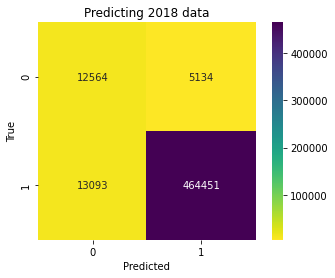

In [29]:
#predicting 2018 data
predictions = cat1.predict(pool_2018)
cm = confusion_matrix(test_target, predictions)
import seaborn as sns
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Predicting 2018 data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

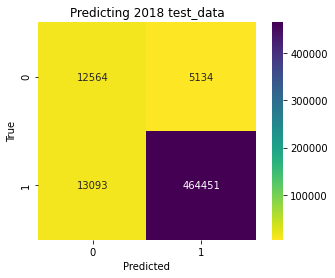

In [45]:
#predicting 2018 data using just test_data dataframe
predictions = cat1.predict(test_data)
cm = confusion_matrix(test_target, predictions)
import seaborn as sns
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Predicting 2018 test_data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [32]:
#computing ROC-AUC score for Catboost on 2018 data 

roc_auc_score(test_target, predictions)

0.841246677752457

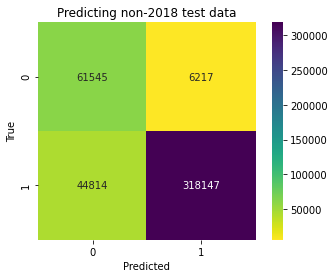

In [34]:
#predicting <2018 test data that model hasn't seen yet
predictions2 = cat1.predict(pool_test)
cm1 = confusion_matrix(y_test, predictions2)
import seaborn as sns
ax = sns.heatmap(cm1, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Predicting non-2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [32]:
#accuracy, precision and recall scores of CatBoost predictions on the 2018 data

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
ac1 = accuracy_score(test_target, predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr1 = precision_score(test_target, predictions)
re1 = recall_score(test_target, predictions)
print('Accuracy Score of %{:.4f}'.format(ac1))
print('Precision Score of %{:.4f}'.format(pr1))
print('Recall Score of %{:.4f}'.format(re1))

Accuracy Score of %0.9632
Precision Score of %0.9891
Recall Score of %0.9726


In [33]:
#accuracy, precision and recall scores of CatBoost predictions on the non-2018 data

ac2 = accuracy_score(y_test, predictions2)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr2 = precision_score(y_test, predictions2)
re2 = recall_score(y_test, predictions2)
print('Accuracy Score of %{:.4f}'.format(ac2))
print('Precision Score of %{:.4f}'.format(pr2))
print('Recall Score of %{:.4f}'.format(re2))

Accuracy Score of %0.8815
Precision Score of %0.9808
Recall Score of %0.8765


In [35]:
#roc_auc_score of Catboost on the non-2018 data 
roc_auc_score(y_test, predictions2)

0.8923923011327715

In [ ]:
#looking at feature importances of CatBoostClassifier model

cat_coefficients = pd.DataFrame(cat1.feature_importances_.reshape(-1))
column_names = pd.DataFrame(x_train_lg.columns.values)
cat_feat_imp = pd.concat([cat_coefficients, column_names], axis = 1)
cat_feat_imp.columns = ['Importance','Feature_Name']
print_full(cat_feat_imp.sort_values(by='Importance', ascending = False))

In [ ]:
#taking the top CatBoostClassifier open_il_12m and annual_inc features and retraining another model 
#to then 3D visualize probability estimation 

#creating data with just our two features 
train_data_2feat = train_data.loc[:,['open_il_12m','annual_inc']]

#creating new train, val and test sets 
x_train_2feat, x_test_2feat, y_train_2feat, y_test_2feat = train_test_split(train_data_2feat, train_target, stratify = train_target, 
                                                    random_state = 0)
x_train_2feat, x_val_2feat, y_train_2feat, y_val_2feat = train_test_split(x_train_2feat, y_train_2feat, stratify = y_train_2feat, 
                                                    random_state = 0)
num1 = y_train.value_counts()
pool_train_2feat = Pool(x_train_2feat, y_train_2feat)
pool_test_2feat = Pool(x_test_2feat, y_test_2feat)
pool_val_2feat = Pool(x_val_2feat, y_val_2feat)

cat2feat = CatBoostClassifier(learning_rate = 0.05,
                          iterations = 1000,
                          early_stopping_rounds=100,
                          class_weights = [1, num[0]/num[1]])

cat2feat.fit(pool_train_2feat, eval_set=pool_val_2feat, plot=True)

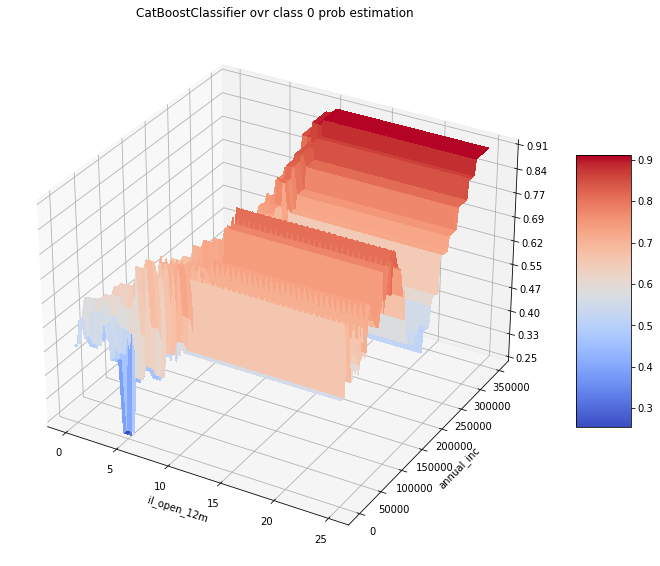

In [160]:
#creating 3D graphic view of open_il_12m vs annual_inc variables

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,25,100)
B = np.linspace(0,350000,100)
A, B = np.meshgrid(A, B)

C = cat1.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,0].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'CatBoostClassifier ovr class 0 prob estimation')
plt.xlabel('il_open_12m')
plt.ylabel('annual_inc')
plt.show()

In [162]:
#predictions using 2-feat Catboost Classifier model 
cat_2feat_predictions = cat2feat.predict(x_test_2feat)

ac_2feat = accuracy_score(y_test_2feat, cat_2feat_predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr_2feat = precision_score(y_test_2feat, cat_2feat_predictions)
re_2feat = recall_score(y_test_2feat, cat_2feat_predictions)
print('2-feat Catboost Classifier model Accuracy Score of %{:.4f}'.format(ac_2feat))
print('2-feat Catboost Classifier model Precision Score of %{:.4f}'.format(pr_2feat))
print('2-feat Catboost Classifier model Recall Score of %{:.4f}'.format(re_2feat))

2-feat Catboost Classifier model Accuracy Score of %0.5397
2-feat Catboost Classifier model Precision Score of %0.8715
2-feat Catboost Classifier model Recall Score of %0.5323


In [23]:
#Merging our data to do logistic regression
re_merged = pd.concat([train_data, test_data], axis = 0)
re_merged = pd.get_dummies(re_merged, drop_first = True)
re_merged.earliest_credit_line_years = re_merged.earliest_credit_line_years.dt.days

re_merged['Year'] = pd.DatetimeIndex(re_merged['issue_d_date']).year
re_merged.drop(['earliest_cr_line_date','issue_d_date'], axis = 1, inplace = True)
#train data is all non-2018 data
traindf2 = re_merged[re_merged['Year'] != 2018]
#target data is all 2018 data 
targetdf2 = re_merged[re_merged['Year'] == 2018]
targetdf2.drop(['Year'], axis = 1, inplace = True)
traindf2.drop(['Year'], axis = 1, inplace = True)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [38]:
#traindf2 is non-2018 data, train_target is non-2018 data 

x_train_lg, x_test_lg, y_train_lg, y_test_lg = train_test_split(traindf2, train_target, random_state = 0,
                                                               test_size = 0.33)

In [127]:
#training a Logistic Regression model on the data
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

class_weight = {1:1, 0:np.round(y_train_lg.value_counts()[1]/y_train_lg.value_counts()[0],2)}

lg1 = LogisticRegression(solver = 'saga', class_weight = {1:1,0:5.36},
                        max_iter = 300, C = 1e3, n_jobs = -1)
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
# cv = StratifiedKFold(n_splits = 3, random_state = 1)
# scores_lg = cross_val_score(lg1, x_train_lg, y_train_lg, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC for Logit Regression: %.3f' % np.mean(scores_lg))

In [128]:
#fitting and predicting our Logistic Regression model
lg1.fit(x_train_lg, y_train_lg)
lg1predictions = lg1.predict(x_test_lg)

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [130]:
#getting Logistic Regression ROC_AUC score for the non-2018 data
roc_auc_score(y_test_lg, lg1predictions)

0.5827488773029093

In [143]:
#getting Logistic Regression ROC_AUC score for the 2018 data

lg1prediction_2018 = lg1.predict(targetdf2)
roc_auc_score(test_target, lg1prediction_2018)

0.5631836143417641

In [30]:
#pickling our lg1 model

with open('lg1.pickle','wb') as lg1_path:
    pickle.dump(lg1, lg1_path)

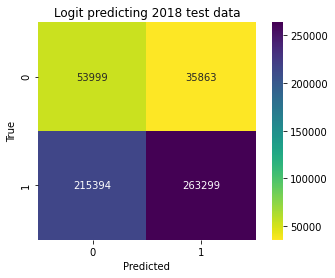

In [43]:
#visualizing the confusion matrix for Logistic Regression model
import seaborn as sns
cm2 = confusion_matrix(y_test_lg, lg1predictions)
ax = sns.heatmap(cm2, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Logit predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [62]:
#accuracy, precision and recall scores of logit predictions on the non-2018 data

ac3 = accuracy_score(y_test_lg, lg1predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr3 = precision_score(y_test_lg, lg1predictions)
re3 = recall_score(y_test_lg, lg1predictions)
print('Logit Accuracy Score of %{:.4f}'.format(ac3))
print('Logit Precision Score of %{:.4f}'.format(pr3))
print('Logit Recall Score of %{:.4f}'.format(re3))

Logit Accuracy Score of %0.5581
Logit Precision Score of %0.8801
Logit Recall Score of %0.5500


In [28]:
#computing ROC-AUC score for Logit

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_lg, lg1predictions)

0.5754776034456511

In [122]:
#viewing most important Logistic Regression features 

lg_coefficients = pd.DataFrame(lg1.coef_.reshape(-1))
column_names = pd.DataFrame(x_train_lg.columns.values)
lg_feat_imp = pd.concat([lg_coefficients, column_names], axis = 1)
lg_feat_imp.columns = ['Importance', 'Feature_Name']

In [ ]:
lg_feat_imp

In [ ]:
print_full(lg_feat_imp.sort_values(by = 'Importance'))

In [ ]:
#using Recursive Feature Elimination with Logistic Regression

from sklearn.feature_selection import RFE
rfe = RFE(estimator=lg1)
rfe = rfe.fit(x_train_lg, y_train_lg)

In [36]:
#NAIVE BAYES

#Quadratic Discriminant Analysis (QDA)
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
QDA.fit(x_train_lg, y_train_lg)


/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(store_covariance=True)

In [37]:
#fitting and predicting with our QDA model
qdapredictions = QDA.predict(x_test_lg)

In [124]:
#computing roc_auc_score of qda model 

roc_auc_score(y_test_lg, qdapredictions)

0.6159814198742477

In [144]:
#getting QDA ROC_AUC score for the 2018 data

qda_prediction_2018 = QDA.predict(targetdf2)
roc_auc_score(test_target, qda_prediction_2018)

0.6407706836078056

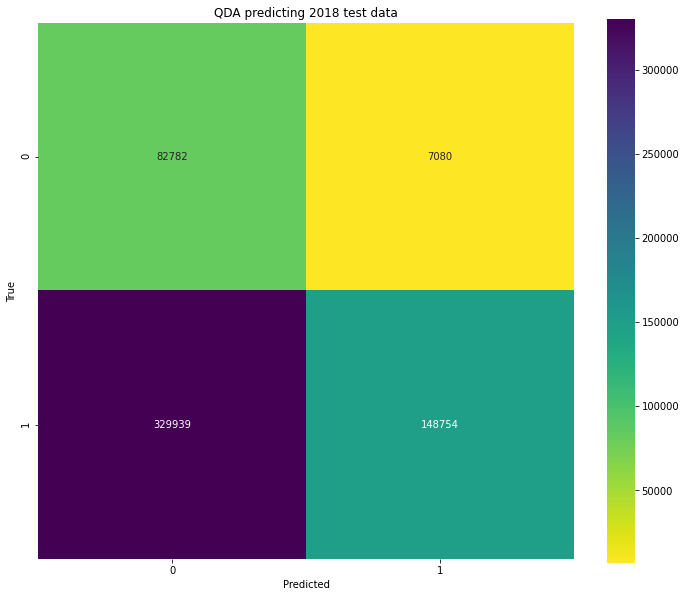

In [165]:
##visualizing the confusion matrix for QDA model
cm5 = confusion_matrix(y_test_lg, qdapredictions)
ax = sns.heatmap(cm5, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('QDA predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [166]:
#accuracy, precision and recall scores of QDA predictions on the non-2018 data

ac5 = accuracy_score(y_test_lg, qdapredictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr5 = precision_score(y_test_lg, qdapredictions)
re5 = recall_score(y_test_lg, qdapredictions)
print('QDA Accuracy Score of %{:.4f}'.format(ac5))
print('QDA Precision Score of %{:.4f}'.format(pr5))
print('QDA Recall Score of %{:.4f}'.format(re5))

Logit Accuracy Score of %0.4072
Logit Precision Score of %0.9546
Logit Recall Score of %0.3108


In [38]:
#roc_auc_score of our QDA model

roc_auc_score(y_test_lg, qdapredictions)

0.6159814198742477

In [119]:
#pickling our qda model 

with open('qda_model.pickle', 'wb') as qda_model_file:
    pickle.dump(QDA, qda_model_file)

In [167]:
x_train_lg.shape

(1154336, 172)

In [52]:
#passing subset of our x_train_lg data for demonstrative purposes 

x_train_lg1 = x_train_lg.iloc[:1000,:]
y_train_lg1 = y_train_lg[:1000]

In [56]:
#creating same-shape dataframes for test data 

x_test_lg1 = x_test_lg.iloc[:1000,:]
y_test_lg1 = y_test_lg[:1000]

In [172]:
x_train_lg1.annual_inc.dtype

dtype('float64')

In [173]:
x_train_lg1[:3]

,loan_amnt,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint,disbursement_method_DirectPay
1041258,10000.0,36,16.29,353.01,11.0,80000.0,39.11,0.0,679.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1708460,15400.0,36,14.99,533.78,6.0,35000.0,12.21,0.0,689.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2057192,32000.0,60,20.00,847.81,11.0,74500.0,16.65,0.0,699.0,2.0,...,0,0,0,0,0,0,0,1,0,0


In [181]:
g = x_train_lg1.loc[104125,['annual_inc']]
g

annual_inc    80000.0
Name: 1041258, dtype: float64

In [64]:
#mySQLdb query to return the same albeit from our smaller accepted_df dataset and a different id
c.execute("""SELECT annual_inc FROM lendingclub3 where id = %s""", ('67275481',))
c.fetchall()

((85000,),)

In [171]:
#pickling our x_train_lg1 data

with open('x_train_lg1.pickle', 'wb') as x_train_lg1_file:
    pickle.dump(x_train_lg1, x_train_lg1_file)

In [70]:
#pickling our y_train_lg1 data

with open('y_train_lg1.pickle', 'wb') as y_train_lg1_file:
    pickle.dump(y_train_lg1, y_train_lg1_file)

In [41]:
#implementing GaussianNB algorithm for classification 
gnb = naive_bayes.GaussianNB()

gnb.fit(x_train_lg, y_train_lg)

GaussianNB()

In [147]:
#getting GaussianNB ROC_AUC score for the 2018 data

gnb_prediction_2018 = gnb.predict(targetdf2)
roc_auc_score(test_target, gnb_prediction_2018)

0.745526726703416

In [161]:
#getting GaussianNB ROC_AUC score for the non-2018 data

gnb_prediction_non2018 = gnb.predict(x_test_lg)
roc_auc_score(y_test_lg, gnb_prediction_non2018)

0.7905714601659427

In [ ]:
#predicting our non-2018 data with fitted GaussianNB model and outputting confusion matrix 

predictions_gnb = gnb.predict(x_test_lg)
cm6 = confusion_matrix(y_test_lg, predictions_gnb)

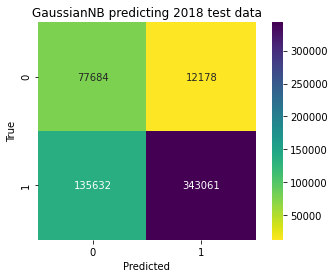

In [44]:
ax = sns.heatmap(cm6, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('GaussianNB predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [173]:
#accuracy, precision and recall scores of GNB predictions on the non-2018 data

ac6 = accuracy_score(y_test_lg, predictions_gnb)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr6 = precision_score(y_test_lg, predictions_gnb)
re6 = recall_score(y_test_lg, predictions_gnb)
print('GaussianNB Accuracy Score of %{:.4f}'.format(ac6))
print('GaussianNB Precision Score of %{:.4f}'.format(pr6))
print('GaussianNB Recall Score of %{:.4f}'.format(re6))

GaussianNB Accuracy Score of %0.7400
GaussianNB Precision Score of %0.9657
GaussianNB Recall Score of %0.7167


In [175]:
sklearn.model_selection.cross_val_score?

Object `sklearn.model_selection.cross_val_score` not found.


In [177]:
#looking at cross_val_scores for GaussianNB

scores_gnb = cross_val_score(gnb, x_train_lg, y_train_lg, scoring='roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC for GaussianNB: %.3f' % np.mean(scores_gnb))

In [149]:
#implementing MNB
mnb = naive_bayes.MultinomialNB()
mnb.fit(x_train_lg, y_train_lg)

MultinomialNB()

In [182]:
#looking at cross_val_scores for MultinomialNB
scores_mnb = cross_val_score(mnb, x_train_lg, y_train_lg, scoring='roc_auc', cv = cv, n_jobs = -1)
print('Mean ROC AUC for MultinomialNB: %.3f' % np.mean(scores_mnb))

Mean ROC AUC for MultinomialNB: 0.559


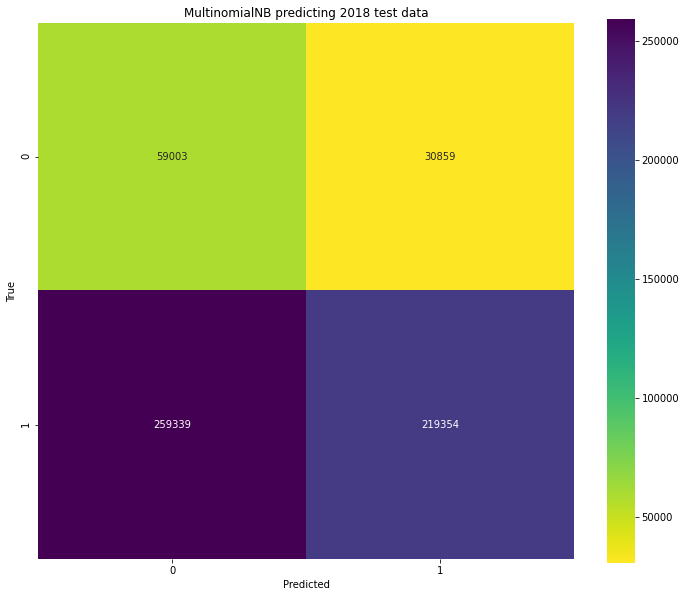

In [183]:
#predicting using MNB
predictions_mnb = mnb.predict(x_test_lg)
cm7 = confusion_matrix(y_test_lg, predictions_mnb)
ax = sns.heatmap(cm7, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('MultinomialNB predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [184]:
#looking at different scores for MultinomialNB
ac8 = accuracy_score(y_test_lg, predictions_mnb)
rs8 = recall_score(y_test_lg, predictions_mnb)
pr8 = precision_score(y_test_lg, predictions_mnb)
print('MultinomialNB Accuracy Score of %{:.4f}'.format(ac8))
print('MultinomialNB Precision Score of %{:.4f}'.format(rs8))
print('MultinomialNB Recall Score of %{:.4f}'.format(pr8))


MultinomialNB Accuracy Score of %0.4896
MultinomialNB Precision Score of %0.4582
MultinomialNB Recall Score of %0.8767


In [150]:
#getting MultinomialNB ROC_AUC score for the 2018 data

mnb_prediction_2018 = mnb.predict(targetdf2)
roc_auc_score(test_target, mnb_prediction_2018)

0.5475818937044846

In [160]:
#getting MultinomialNB ROC_AUC score for the non-2018 data

mnb_prediction_non2018 = mnb.predict(x_test_lg)
roc_auc_score(y_test_lg, mnb_prediction_non2018)

0.5574154526384514

In [132]:
#implementing Linear Discriminant Analysis (LDA)
from sklearn import discriminant_analysis
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(x_train_lg, y_train_lg)

LinearDiscriminantAnalysis()

In [153]:
#getting LDA ROC_AUC score for the 2018 data

ldaprediction_2018 = lda.predict(targetdf2)
roc_auc_score(test_target, ldaprediction_2018)

0.7558750945909043

In [159]:
#getting LDA ROC_AUC score for the non-2018 data

ldaprediction_non2018 = lda.predict(x_test_lg)
roc_auc_score(y_test_lg, ldaprediction_non2018)

0.8302350480232723

In [102]:
#pickling our lda model 

with open('lda_model.pickle', 'wb') as lda_model_file:
    pickle.dump(lda, lda_model_file)

In [ ]:
#looking at cross_val_scores for Linear Discriminant Analysis
scores_lda = cross_val_score(lda, x_train_lg, y_train_lg, scoring = 'roc_auc', cv = cv, n_jobs = -1)


In [238]:
print('LinearDiscriminantAnalysis Mean Score of: %{:.3f}'.format(np.mean(scores_lda)))

LinearDiscriminantAnalysis Mean Score of: %0.943


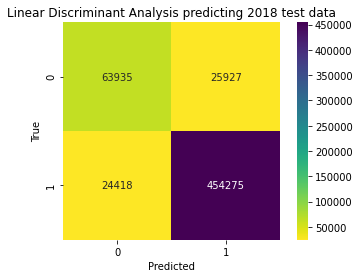

In [133]:
#predicting using LDA
predictions_lda = lda.predict(x_test_lg)
cm10 = confusion_matrix(y_test_lg, predictions_lda)
ax = sns.heatmap(cm10, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('Linear Discriminant Analysis predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [134]:
roc_auc_score(predictions_lda, y_test_lg)

0.8348197403488269

In [192]:
#accuracy, precision and recall scores of GNB predictions on the non-2018 data

ac10 = accuracy_score(y_test_lg, predictions_gnb)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr10 = precision_score(y_test_lg, predictions_gnb)
re10 = recall_score(y_test_lg, predictions_gnb)
print('LinearDiscriminantAnalysis Accuracy Score of %{:.4f}'.format(ac10))
print('LinearDiscriminantAnalysis Precision Score of %{:.4f}'.format(pr10))
print('LinearDiscriminantAnalysis Recall Score of %{:.4f}'.format(re10))


LinearDiscriminantAnalysis Accuracy Score of %0.7400
LinearDiscriminantAnalysis Precision Score of %0.9657
LinearDiscriminantAnalysis Recall Score of %0.7167


In [194]:
#implementing RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 500, criterion = 'gini', class_weight = {1:1,0:5.36})
# scores_rf = cross_val_score(rf1, x_train_lg, y_train_lg, scoring='roc_auc', cv = cv, n_jobs = -1)
# print('Mean ROC AUC for Random Forests Classifier: %.3f' % np.mean(scores_rf))

In [155]:
#loading in trained RandomForests Model 
import joblib

rf2 = joblib.load('finalized_model.sav')

In [156]:
#getting ROC_AUC Score for 2018 data from our loaded Random Forests Model
rf2_prediction_2018 = rf2.predict(targetdf2)
roc_auc_score(test_target, rf2_prediction_2018)

0.6968978245598481

In [158]:
#getting ROC_AUC Score for non-2018 data from our loaded Random Forests Model
rf2_prediction_non2018 = rf2.predict(x_test_lg)
roc_auc_score(y_test_lg, rf2_prediction_non2018)

0.7689165215374484

In [ ]:
#fitting and predicting with our RandomForestClassifier model
rf1.fit(x_train_lg, y_train_lg)
rf1predictions = rf1.predict(x_test_lg)

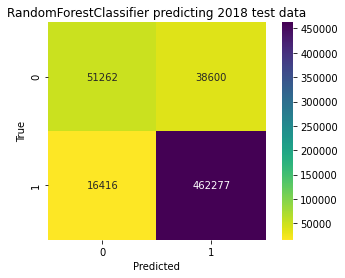

In [69]:
##visualizing the confusion matrix for RandomForestClassifier model on non-2018 data 
cm3 = confusion_matrix(y_test_lg, rf1predictions)
ax = sns.heatmap(cm3, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('RandomForestClassifier predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [71]:
#accuracy, precision and recall scores of RandomForestClassifier predictions on the non-2018 data

ac4 = accuracy_score(y_test_lg, rf1predictions)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr4 = precision_score(y_test_lg, rf1predictions)
re4 = recall_score(y_test_lg, rf1predictions)
print('Logit Accuracy Score of %{:.4f}'.format(ac4))
print('Logit Precision Score of %{:.4f}'.format(pr4))
print('Logit Recall Score of %{:.4f}'.format(re4))

Logit Accuracy Score of %0.9032
Logit Precision Score of %0.9229
Logit Recall Score of %0.9657


In [39]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators = 300, max_depth = 4, validation_fraction = 0.2, n_iter_no_change = 50)
gbc.fit(x_train_lg, y_train_lg)

GradientBoostingClassifier(max_depth=4, n_estimators=300, n_iter_no_change=50,
                           validation_fraction=0.2)

In [151]:
#getting GradientBoosting ROC_AUC score for the 2018 data

gbcprediction_2018 = gbc.predict(targetdf2)
roc_auc_score(test_target, gbcprediction_2018)

0.7662183870922619

In [32]:
with open('gbc.pickle','wb') as gbc_file:
    pickle.dump(gbc, gbc_file)

In [126]:
predictions_gbc = gbc.predict(x_test_lg)
cm12 = confusion_matrix(y_test_lg, predictions_gbc)

In [ ]:
scores_gbc = cross_val_score(gbc, x_train_lg, y_train_lg, scoring='roc_auc', cv=cv, n_jobs=-1)

In [135]:
#getting single roc_auc_score, not cross-validated

roc_auc_score(y_test_lg, predictions_gbc)

0.8305568754041475

In [205]:
from sklearn.model_selection import GridSearchCV
param_grid_gbc = {'max_depth':[3,4]}
grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, scoring = 'roc_auc', cv = 3, n_jobs = -1,)

In [ ]:
grid_search_gbc.fit(x_train_lg, y_train_lg)

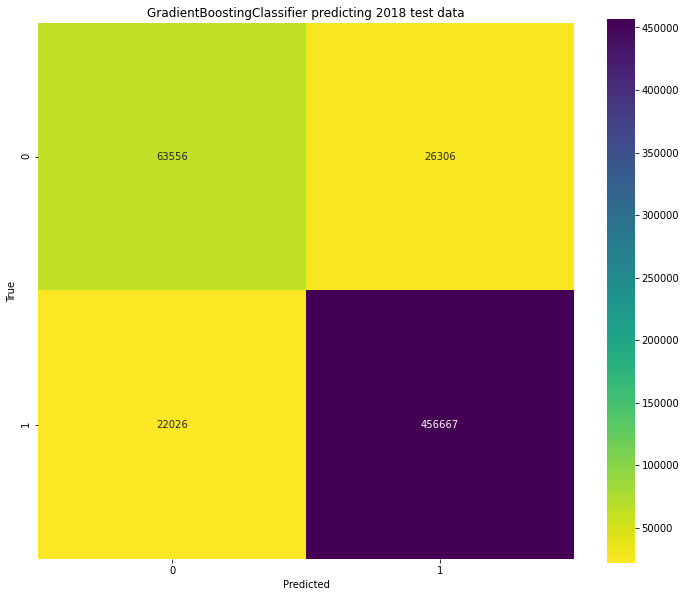

In [207]:
predictions_gbc = gbc.predict(x_test_lg)
cm11 = confusion_matrix(y_test_lg, predictions_gbc)
ax = sns.heatmap(cm11, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_title('GradientBoostingClassifier predicting 2018 test data')
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [209]:
predicted_gbc = gbc.predict_proba(x_test_lg)

In [275]:
concatdf['diff'] = np.where(concatdf['t1'] != 6, 1, 0)

In [ ]:
concatdf['test'] = np.where((concatdf['t1'] == 6) and (concatdf['diff'] == 1), 1, 0)

In [ ]:
def classification_adj(x_test_lg2, cutoff_values): #x_test_lg2 is your DataFrame with the Profit feature
    cutoff_values2 = cutoff_values[:]

    global answer
    answer = []
    
    newarr = [0] * x_test_lg2.shape[0]
    
    for cutoff in cutoff_values:
        x_test_lg2['Predicted'] = np.where(x_test_lg2['Bad_Loan'] > cutoff, 0, 1)

        x_test_lg2['cf_diff'] = np.where((x_test_lg2['Predicted'] == 0) & (x_test_lg2['True'] == 1), 
                                        x_test_lg2['False_Negative_Cost'], 
                                        np.where((x_test_lg2['Predicted'] == 1) & (x_test_lg2['True'] == 0),
                                        -1 * x_test_lg2['loan_amnt'], 0))
        
        tuple1 = tuple([cutoff, np.sum(x_test_lg2['cf_diff'])])
        answer.append(tuple1)
        
    return answer

classification_adj(x_test_lg2, list(np.linspace(0,1,100)))

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(list(zip(*answer))[0],list(zip(*answer))[1])

In [25]:
#concatenating our predict_prob_cat  array to our test_data dataframe to avoid concatenation duplication later on

test_data2 = test_data.reset_index()
predict_prob_cat = pd.DataFrame(cat1.predict_proba(test_data), columns = ['Bad_Loan','Good_Loan'])
test_data2 = pd.concat([test_data2, predict_prob_cat], axis = 1)
test_data2.drop(['index'], axis = 1, inplace = True)

#making our y_test_lg Series into a DataFrame and concatenating this to our x_test_lg2
new_test_target = pd.DataFrame(test_target).reset_index()
new_test_target.drop(['index'], axis = 1, inplace = True)
new_test_target.columns = ['True']
test_data2 = pd.concat([test_data2, new_test_target], axis = 1)

#creating a new Profit feature based on loan amount, term, installment, and predicted default probability
#this will be the global metric used when optimizing for cutoff value 
test_data2['False_Negative_Cost'] = (test_data2['Good_Loan'] * test_data2['installment'] * test_data2['term'] * -1)

In [ ]:
classification_adj(test_data2, list(np.linspace(0,1,100)))

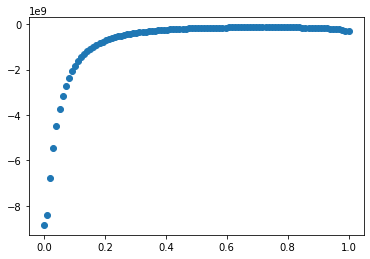

In [216]:
#visualizing cutoff threshold scatter plot for our cat boost model 
import matplotlib.pyplot as plt
plt.scatter(list(zip(*answer))[0],list(zip(*answer))[1])

In [ ]:
#accuracy, precision and recall scores of GradientBoostingClassifier predictions on non-2018 data

ac11 = accuracy_score(y_test_lg, predictions_gbc)
#since false positive are more harmful than false negatives, precision_score is the most important metric to track here
pr11 = precision_score(y_test_lg, predictions_gbc)
re11 = recall_score(y_test_lg, predictions_gbc)
print('GradientBoostingClassifier Accuracy Score of %{:.4f}'.format(ac11))
print('GradientBoostingClassifier Precision Score of %{:.4f}'.format(pr11))
print('GradientBoostingClassifier Recall Score of %{:.4f}'.format(re11))

In [27]:
def cashflowseries(installment, loan_amnt, term, default_rate):
    
    dates36 = ['10/1/2020','11/1/2020','12/1/2020',
         '1/1/2021','2/1/2021','3/1/2021','4/1/2021','5/1/2021','6/1/2021',
         '7/1/2021','8/1/2021','9/1/2021','10/1/2021','11/1/2021','12/1/2021',
         '1/1/2022','2/1/2022','3/1/2022','4/1/2022','5/1/2022','6/1/2022',
         '7/1/2022','8/1/2022','9/1/2022','10/1/2022','11/1/2022','12/1/2022',
         '1/1/2023','2/1/2023','3/1/2023','4/1/2023','5/1/2023','6/1/2023',
         '7/1/2023','8/1/2023','9/1/2023','10/1/2023']
    dates60 = ['10/1/2020','11/1/2020','12/1/2020',
         '1/1/2021','2/1/2021','3/1/2021','4/1/2021','5/1/2021','6/1/2021',
         '7/1/2021','8/1/2021','9/1/2021','10/1/2021','11/1/2021','12/1/2021',
         '1/1/2022','2/1/2022','3/1/2022','4/1/2022','5/1/2022','6/1/2022',
         '7/1/2022','8/1/2022','9/1/2022','10/1/2022','11/1/2022','12/1/2022',
         '1/1/2023','2/1/2023','3/1/2023','4/1/2023','5/1/2023','6/1/2023',
         '7/1/2023','8/1/2023','9/1/2023','10/1/2023','11/1/2023','12/1/2023',
          '1/1/2024','2/1/2024','3/1/2024','4/1/2024','5/1/2024','6/1/2024',
         '7/1/2024','8/1/2024','9/1/2024','10/1/2024','11/1/2024','12/1/2024',
         '1/1/2025','2/1/2025','3/1/2025','4/1/2025','5/1/2025','6/1/2025',
         '7/1/2025','8/1/2025','9/1/2025','10/1/2025']
    
    datelist = []
    
    if term == 36:
        dates = dates36
        for idx, x in enumerate(dates):
            if idx == 0:
                datelist.append(tuple([pd.to_datetime(dates[idx]), loan_amnt * -1]))
            else:
                datelist.append(tuple([pd.to_datetime(dates[idx]), installment * default_rate]))
                
    elif term == 60:
        dates = dates60
        for idx, x in enumerate(dates):
            if idx == 0:
                datelist.append(tuple([pd.to_datetime(dates[idx]), loan_amnt * -1]))
            else:
                datelist.append(tuple([pd.to_datetime(dates[idx]), installment * default_rate]))    
    return datelist
    

In [222]:
test_data2['ave_default'] = (1 - test_data2['Bad_Loan'])

In [ ]:
test_data2['ave_non_default'] = (1 - test_data2['Bad_Loan'])

In [28]:
test_data2['cashflows'] = test_data2.apply(lambda x: cashflowseries(x.installment, x.loan_amnt, x.term, x.ave_non_default), axis = 1)

In [30]:
from scipy import optimize
def xnpv(rate,cashflows):
    """
    Calculate the net present value of a series of cashflows at irregular intervals.
    Arguments
    ---------
    * rate: the discount rate to be applied to the cash flows
    * cashflows: a list object in which each element is a tuple of the form (date, amount), where date is a python datetime.date object and amount is an integer or floating point number. Cash outflows (investments) are represented with negative amounts, and cash inflows (returns) are positive amounts.
    
    Returns
    -------
    * returns a single value which is the NPV of the given cash flows.
    Notes
    ---------------
    * The Net Present Value is the sum of each of cash flows discounted back to the date of the first cash flow. 
    The discounted value of a given cash flow is A/(1+r)**(t-t0), where A is the amount, r is the discout rate, 
    and (t-t0) is the time in years from the date of the first cash flow in the series (t0) to the date of the cash flow 
    being added to the sum (t).  
    * This function is equivalent to the Microsoft Excel function of the same name. 
    """
    chron_order = sorted(cashflows, key = lambda x: x[0])
    t0 = chron_order[0][0] #t0 is the date of the first cash flow

    try:
        return sum([cf/(1+rate)**((t-t0).days/365.0) for (t,cf) in chron_order])
    except:
        print('Error')
    return 0
    

def xirr(cashflows,guess=0):
    """
    Calculate the Internal Rate of Return of a series of cashflows at irregular intervals.
    Arguments
    ---------
    * cashflows: a list object in which each element is a tuple of the form (date, amount), 
    where date is a python datetime.date object and amount is an integer or floating point number. 
    Cash outflows (investments) are represented with negative amounts, and cash inflows (returns) are positive amounts.
    * guess (optional, default = 0.1): a guess at the solution to be used as a starting point for the numerical solution. 
    Returns
    --------
    * Returns the IRR as a single value
    
    Notes
    ----------------
    * The Internal Rate of Return (IRR) is the discount rate at which the Net Present Value (NPV) of a series of cash flows is equal to zero. The NPV of the series of cash flows is determined using the xnpv function in this module. The discount rate at which NPV equals zero is found using the secant method of numerical solution. 
    * This function is equivalent to the Microsoft Excel function of the same name.
    * For users that do not have the scipy module installed, there is an alternate version (commented out) that uses the secant_method function defined in the module rather than the scipy.optimize module's numerical solver. Both use the same method of calculation so there should be no difference in performance, but the secant_method function does not fail gracefully in cases where there is no solution, so the scipy.optimize.newton version is preferred.
    """

    return optimize.brentq(lambda r: xnpv(r,cashflows),-0.99999, 100)


In [31]:
test_data2['xirr'] = test_data2['cashflows'].apply(lambda x: xirr(x))

In [ ]:
test_data2['xirr']

In [34]:
cashflows1 = test_data2['cashflows'][:]

In [36]:
test_data2.drop(['cashflows'], axis = 1, inplace = True)

In [ ]:
#Looking at feature importances of catboost classifieralgorithm 
importances = cat1.feature_importances_
feat_imp_df = pd.DataFrame([x_train.columns.values, importances]).T   
feat_imp_df.columns = ['Feature','Imp']
print_full(feat_imp_df.sort_values(by = 'Imp', ascending = False))

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 1)
test1 = imputer.fit_transform(accepted_df[['num_rev_accts','total_acc']])
test1

In [ ]:
#come back to this later --last_credit_pull_d
#missing value should be filled with mode of observations with same issue_d --use groupby
accepted_df2 = accepted_df['last_credit_pull_d'].fillna(accepted_df.groupby(['issue_d']).transform(lambda x: x.mode().iloc[0]))
print_full(pd.DataFrame(accepted_df2))

accepted_df['last_credit_pull_d'] = accepted_df.groupby(['issue_d'])['last_credit_pull_d'].agg(pd.Series.mode)

In [230]:
accepted_df_na2 = (accepted_df.isna().sum()).reset_index()
accepted_df_na2.columns = ['Feature','NAs']
print_full(accepted_df_na2[accepted_df_na2['NAs'] > 0 ].sort_values(by = ['NAs']))

Empty DataFrame
Columns: [Feature, NAs]
Index: []


In [ ]:
#imputing missing values in certain columns with simple linear regression
from sklearn.linear_model import LinearRegression
regress_features = ['dti']
lnreg = LinearRegression()
for x in regress_features:
    missing_index = accepted_df[x].isna().index
    accepted_df[x] = 

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=1, random_state=0)
imp.fit(accepted_df[num_feat])
imp.transform(accepted_df['dti'])

In [17]:
from sklearn.impute import SimpleImputer
df1 = pd.DataFrame([[1,np.nan,3],[4,5,np.nan]], columns = ['a','b','c'])
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean.fit(df1)
X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
imp_mean.transform(X)

array([[ 2.5,  2. ,  3. ],
       [ 4. ,  5. ,  6. ],
       [10. ,  5. ,  9. ]])

In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.fit(X, y, epochs=150, batch_size=10)

In [51]:
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

24/24 [==============================] - 0s 2ms/step - loss: 0.4751 - accuracy: 0.7731
Accuracy: 77.31


In [86]:
x_train_lg2 = x_train_lg #[:50000]
x_test_lg2 = x_test_lg #[:50000]
y_train_lg2 = y_train_lg #[:50000]
y_test_lg2 = y_test_lg #[:50000]

In [87]:
#implementing a neural network on our Lending Club dataset 
#scaling non-2018 data 

cols = x_train_lg1.columns
cols = list(cols)

x = x_train_lg2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train = pd.DataFrame(x_scaled)
X_train.columns = cols

x = x_test_lg2.values #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)
X_test = pd.DataFrame(x_scaled)
X_test.columns = cols

In [169]:
#scaling 2018 data to make predictions using neural net trained on non-2018 data 

cols2 = targetdf2.columns
cols2 = list(cols)

x2 = targetdf2.values #returns a numpy array
x2_scaled = min_max_scaler.fit_transform(x2)
X_train_2018 = pd.DataFrame(x2_scaled)
X_train_2018.columns = cols2

In [88]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test_lg2, test_size = 0.50, random_state = 777)

In [89]:
#train neural network and use F1 as evaluation metric

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras import optimizers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from matplotlib import pyplot 

model = Sequential()
model.add(Dense(4096, input_shape = (len(X_train.columns),), activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='linear'))
model.add(Dense(1, activation = 'sigmoid'))

opt = optimizers.RMSprop(lr=0.00001) # default is 0.001
model.compile(optimizer = opt,
             loss = 'binary_crossentropy',
             metrics = ['accuracy', f1])

# Adjust the weights of the classes since your dataset is HIGHLY IMBALANCED!
class_weight = {0: 4.25,
                1: 1.}

model.fit(X_train,
         y_train_lg2,
         epochs = 4,
         batch_size = 512,
         validation_data = (X_val, y_val), class_weight=class_weight,
         callbacks=[EarlyStopping(monitor='val_f1', mode='max', patience=30, restore_best_weights=True)])

#let's get the training and validation accuracies for plotting
val_acc = model.history.history['val_acc']
acc = model.history.history['acc']


In [91]:
val_acc = model.history.history['val_accuracy']
acc = model.history.history['accuracy']

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 4096)              708608    
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              8390656   
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)              

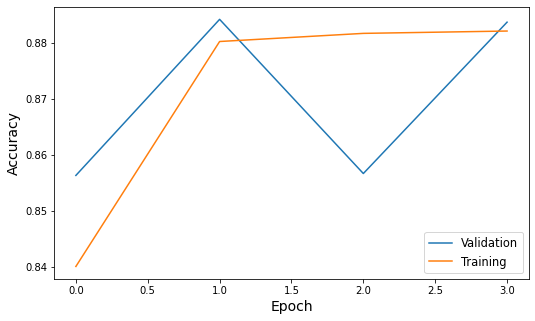

In [92]:
print(model.summary())
# let's plot the performance curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_acc, label='Validation')
plt.plot(acc, label = 'Training')
plt.gcf().set_size_inches(8.5, 5)
plt.xlabel('Epoch',size=14)
plt.ylabel('Accuracy',size=14)
plt.legend(loc="lower right", prop={'size':11.5})
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_prediction = model.predict_classes(X_test)
print("The Test Accuracy of the model is: {} %".format(accuracy_score(y_test, y_prediction) * 100.)) 
print()

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_prediction))
print()

from sklearn.metrics import classification_report
target_names = ['Charged Off', 'Fully Paid']
print(classification_report(y_test, y_prediction, target_names=target_names))

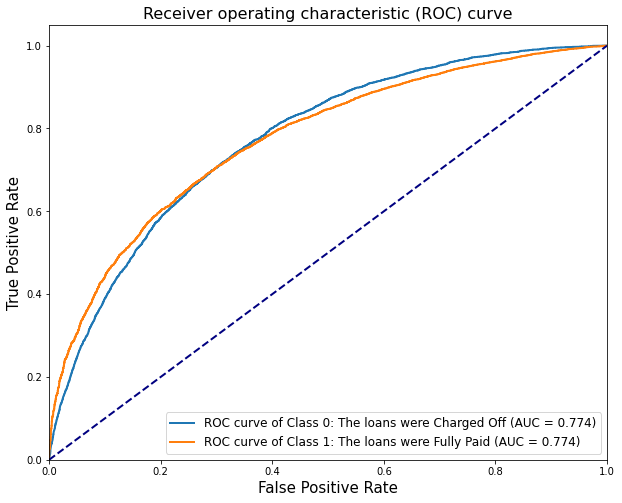

In [85]:
import numpy as np

prob = model.predict(X_test)
full_prob = np.zeros((y_test.shape[0],2))
full_prob[:,0] = 1-np.squeeze(prob)
full_prob[:,1] = np.squeeze(prob)

y_test_array = np.asarray(y_test)
y_test_ar = np.zeros((y_test.shape[0],2))
for i in range(0, y_test.shape[0]):
  if y_test_array[i] == 0:
    y_test_ar[i,0] = 1
  else:
    y_test_ar[i,1] = 1
    
    
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = ["0: The loans were Charged Off", "1: The loans were Fully Paid"]
for i in range(0,2):
    fpr[i], tpr[i], _ = roc_curve(y_test_ar[:, i], full_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(10,8))
lw = 2
for i in range(2):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of Class {0} (AUC = {1:0.3f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver operating characteristic (ROC) curve',fontsize=16)
plt.legend(loc="lower right",fontsize=12)
plt.show()

In [103]:
#serializing our model and saving to disk in order to load into our application later on
model.save('model.h5')

In [137]:
predictions_nn = model.predict_classes(X_test)
roc_auc_score(y_test, predictions_nn)

0.883799839809199

In [173]:
machine_learning_results = pd.DataFrame({'Model':['Logistic Regression','Linear Discriminant Analysis','Quadratic Discriminant Analysis',
    'Multinomial Naive Bayes','Gaussian Naive Bayes','Gradient Boosting Classifier','Random Forest Classifier','Catboost Classifier','MLP Neural Net'],
    'Non-2018 test data AUC score':[0.583, 0.830, 0.616, 0.557, 0.791, 0.831, 0.769, 0.892, 0.884], 
    '2018 test data AUC score':[0.563, 0.756, 0.641, 0.548, 0.756, 0.766, 0.697, 0.841, 0.816]})
machine_learning_results

,Model,Non-2018 test data AUC score,2018 test data AUC score
0,Logistic Regression,0.583,0.563
1,Linear Discriminant Analysis,0.830,0.756
2,Quadratic Discriminant Analysis,0.616,0.641
3,Multinomial Naive Bayes,0.557,0.548
4,Gaussian Naive Bayes,0.791,0.756
5,Gradient Boosting Classifier,0.831,0.766
6,Random Forest Classifier,0.769,0.697
7,Catboost Classifier,0.892,0.841
8,MLP Neural Net,0.884,0.816


In [ ]:
machine_learning_results.to_dict('records')

In [171]:
#predicting 2018 data using neural net model 

predictions_nn2 = model.predict_classes(X_train_2018)
roc_auc_score(test_target, predictions_nn2)

0.8155649094337568

In [118]:
#model predictions

model.predict(X_test.loc[323571:323571,:])[0][0]

0.967451

In [175]:
#outputting confusion matrix for neural net 

cm_nn = confusion_matrix(test_target, predictions_nn2)

In [176]:
cm_nn

array([[ 11764,   5934],
       [ 16035, 461509]])

In [177]:
accepted_df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bc_limit,total_il_high_credit_limit,disbursement_method,issue_d_date,Year,earliest_cr_line_date,earliest_credit_line_years
0,3600.0,36,13.99,123.03,C4,11.0,MORTGAGE,55000.0,Not Verified,1,...,0.0,0.0,178050.0,2400.0,13734.0,Cash,2015-12-15,2015,2003-08-15,4505 days
1,24700.0,36,11.99,820.28,C1,11.0,MORTGAGE,65000.0,Not Verified,1,...,0.0,0.0,314017.0,79300.0,24667.0,Cash,2015-12-15,2015,1999-12-15,5844 days
2,20000.0,60,10.78,432.66,B4,11.0,MORTGAGE,63000.0,Not Verified,1,...,0.0,0.0,218418.0,6200.0,14877.0,Cash,2015-12-15,2015,2000-08-15,5600 days
3,35000.0,60,14.85,829.90,C5,11.0,MORTGAGE,110000.0,Source Verified,1,...,0.0,0.0,381215.0,62500.0,18000.0,Cash,2015-12-15,2015,2008-09-15,2647 days
4,10400.0,60,22.45,289.91,F1,3.0,MORTGAGE,104433.0,Source Verified,1,...,0.0,0.0,439570.0,20300.0,88097.0,Cash,2015-12-15,2015,1998-06-15,6392 days


In [50]:
test_data2['Predicted'] = np.where((test_data2['Good_Loan'] > 0.7373737373737), 1, 0)

In [56]:
test_data2.loc[0,'True'] / test_data2.loc[1,'True']

1.0

In [62]:
test_data2['True'].value_counts()[0] / test_data2['True'].value_counts()[1]

0.037060459350342585

In [63]:
test_data2['Predicted'].value_counts()[0] / test_data2['Predicted'].value_counts()[1]

0.10529546068298432

In [66]:
test_data2['Profit'] = np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 0), test_data2['loan_amnt'] * -1,
                             np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 1),
                                     test_data2['installment'] * test_data2['term'],0))

In [67]:
test_data2['Profit'].sum()

8914328811.44

In [68]:
test_data2['Total_IRR'] = np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 0), 0,
                             np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 1),
                                     test_data2['xirr'],0))

In [78]:
test_data2['PredictAll1'] = 1

In [ ]:
test_data2['Total_IRR'] = np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 0), 0,
                             np.where((test_data2['Predicted'] == 1) & (test_data2['True'] == 1),
                                     test_data2['xirr'],0))

In [ ]:
groupby_term = test_data2.groupby(['term'])['Total_IRR'].agg('mean')
groupby_term = pd.DataFrame(groupby_term)

In [79]:
test_data2['Total_IRR_Dumb_Model'] = np.where((test_data2['PredictAll1'] == 1) & (test_data2['True'] == 0), 0,
                             np.where((test_data2['PredictAll1'] == 1) & (test_data2['True'] == 1),
                                     test_data2['xirr'],0))

In [82]:
groupby_term_dumb = test_data2.groupby(['term'])['Total_IRR_Dumb_Model'].agg('mean')
groupby_term_dumb = pd.DataFrame(groupby_term_dumb)

In [83]:
groupby_term_dumb

,Total_IRR_Dumb_Model
term,
36,0.058941
60,0.096728


In [76]:
groupby_term

,Total_IRR
term,
36,0.073926
60,0.106258


In [86]:
#36-month loans 

#comparing variances of the two groups to see if we can assume equal variance when performing two sample t-test
group1 = test_data2['Total_IRR']
group2 = test_data2['Total_IRR_Dumb_Model']
print(np.var(group2) / np.var(group1))
#since their ratio is <4, we can assume equal variances for our two sample t-test

3.062550742374941


In [87]:
import scipy.stats as stats

stats.ttest_ind(a=group1, b=group2, equal_var=True)

Ttest_indResult(statistic=78.24354390640326, pvalue=0.0)

In [90]:
with open('test_data2.pickle','wb') as test_data2_file:
     pickle.dump(test_data2, test_data2_file)

In [159]:
test_data3 = test_data2[['home_ownership','purpose','addr_state','loan_amnt','term','int_rate','installment',
                            'True_IRR','xirr']]

In [ ]:
test_data3.rename(columns = {'home_ownership':'Home_Ownership_Status','purpose':'Loan_Purpose','addr_state':'State',
                         'loan_amnt':'Loan_Amount','term':'Loan_Term','int_rate':'Loan_Interest_Rate',
                        'installment':'Loan_Installment','Total_IRR':'True_IRR','xirr':'Predicted_IRR'}, inplace = True) 

In [142]:
test_data3 = test_data3[['Home_Ownership_Status', 'Loan_Purpose','State',
                         'Loan_Amount','Loan_Term','Loan_Interest_Rate','Loan_Installment','Predicted_IRR','True_IRR']]

In [127]:
test_data2.rename(columns = {'Predicted_IRR':'xirr','Loan_Installment':'Installment'}, inplace = True)

In [ ]:
test_data3 = test_data3.loc[test_data3['Predicted_IRR'] > 0.01]
test_data3 = test_data3.sort_values('Predicted_IRR', ascending = False)
test_data3.head()

In [ ]:
test_data3 = test_data3.sample(50000)
test_data3.head()

In [164]:
with open('test_data2.pickle','wb') as test_data3_file:
     pickle.dump(test_data3, test_data3_file)

In [95]:
list(test_data2['home_ownership'].unique())

['RENT', 'OWN', 'MORTGAGE', 'ANY']

In [ ]:
purposes = []
for x in list(test_data2['purpose'].unique()):
    purposes.append({'label':x,'value':x})
purposes